# 注意力机制
## 注意力提示
- “注意力”：指的是模型分配给它所处理信息中不同部分的权重或重要性分数。
- “提示”：指的是引导模型如何分配这些权重的线索或指令。
- 过程解释：编码器读取输入序列，每个输入词都生成一个隐藏状态，解码器初始化开始生成第一个目标词的时候，它自己的隐藏状态（比如$s_0$）来自编码器的最后一个状态（因为最后一个状态通常包含整个输入序列的信息）或者使用一个特殊的开始标记（提醒解码器开始解码）（一般是解码器自己有一个初始向量或者这个开始标记带着一个学习向量），然后就根据这个初始的向量和编码器的输出向量通过注意力机制计算（用初始向量去乘以每一个编码器的隐藏状态，得到他们各自对应的分数（这个结果就是概率，即相关性），然后将这个分数使用$\mathrm{Softmax}$函数标准化成总和为$1$的概率分布（权重），然后这个权重就是最终的**注意力提示**（模型会注意权重高的）），然后就是上下文向量的更新，各个权重乘以编码器对应位置的各个隐藏状态相加就是更新后的上下文向量（主要是权重最大的对应的隐状态的信息），然后解码器生成第一个词（将初始向量和上下文向量拼接在一起，通过一个前馈神经网络和一个$\mathrm{softmax}$层，然后得到一个覆盖整个目标词汇表的概率分布，概率最高的就是模型预测的第一个词），在之后就是重复上述步骤，直到生成整个序列。
- 注意力机制框架：

![注意力机制框架图](../image/AttentionMechanismFramework.jpg)



## 注意力汇聚：$\mathrm{Nadaraya-Watson}$核回归
### 数据集生成
- 使用非线性函数：$y_i=2\sin(x_i)+x_i^{0.8}+\epsilon$，其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布

### 平均汇聚
$$f(x)=\frac{1}{n}\sum^n_{i=1}y_i$$

In [1]:
import collections
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

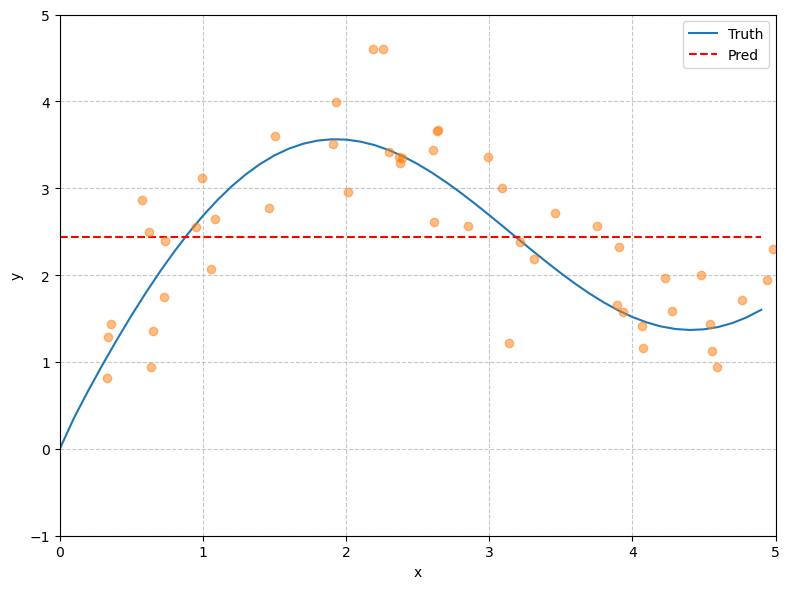

In [2]:
import torch
import matplotlib.pyplot as plt

# 生成数据
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)

def plot_kernel_reg(y_hat):
    fig, ax = plt.subplots(figsize=(8, 6))
    # 设置白色背景
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    ax.plot(x_test, y_truth, label='Truth')
    # 红色虚线
    ax.plot(x_test, y_hat, 'r--', label='Pred')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([0.0, 5.0])
    ax.set_ylim([-1, 5])
    ax.legend()
    ax.plot(x_train, y_train, 'o', alpha=0.5)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 非参数注意力汇聚
- $\mathrm{Nadaraya-Watson}$核回归:
$$f(x)=\sum^n_{i=1}\frac{K(x-x_i)}{\sum_{j=1}^nK(x-x_j)}y_i$$
- 其中$K$是核（函数），由此得出通用的注意力汇聚公式：
$$f(x)=\sum^n_{i=1}\alpha(x,x_i)y_i$$
- 其中$x$是查询，$(x_i,y_i)$是键值对，注意力权重$\alpha(x,x_i)$是查询$x$和键$x_i$之间的关系建模（键越接近查询，那么分配给这个键对应的$y_i$的注意力权重会越大（考虑到一些具体的核函数上））
- **注**：对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：它们是非负的，并且总和为1。

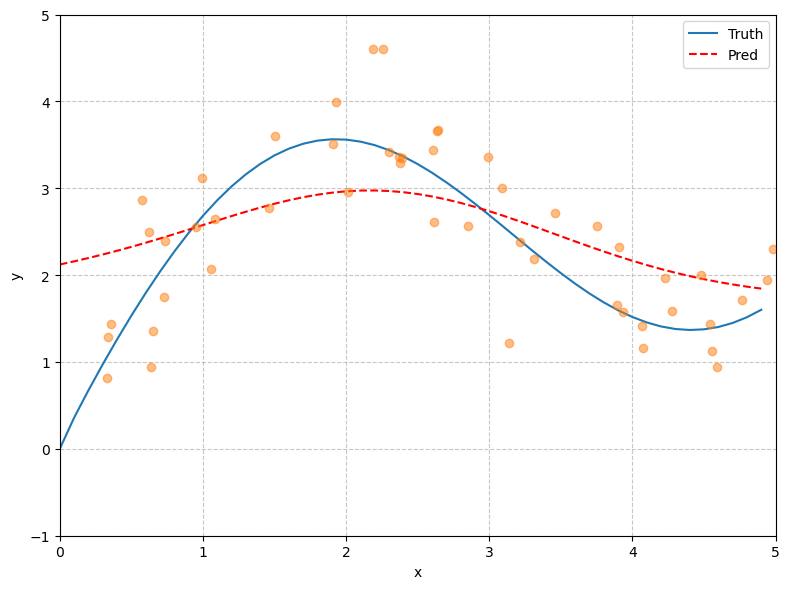

In [3]:
import torch.nn as nn
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

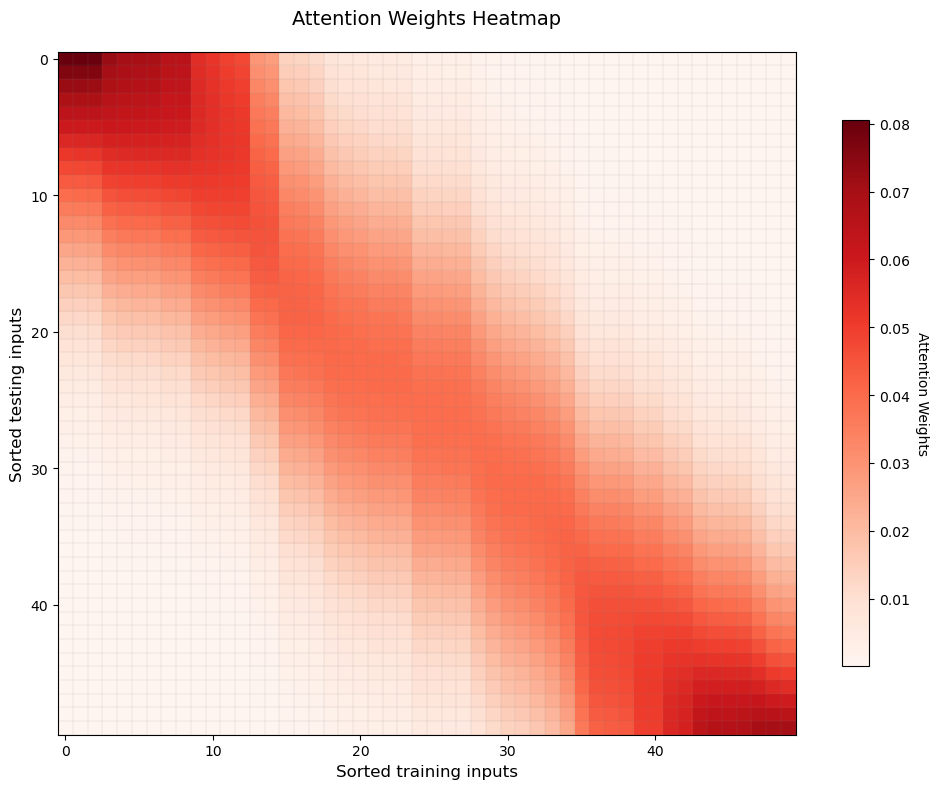

In [4]:


def show_heatmaps(attention_weights, xlabel='Sorted training inputs', ylabel='Sorted testing inputs',
                 title='Attention Weights Heatmap', figsize=(10, 8), cmap='Reds'):
    """
    显示注意力权重的热力图
    
    参数:
    attention_weights: 注意力权重矩阵 (测试样本数, 训练样本数)
    xlabel: x轴标签
    ylabel: y轴标签
    title: 图标题
    figsize: 图形大小
    cmap: 颜色映射
    """
    # 转换张量为numpy数组
    if hasattr(attention_weights, 'detach'):
        data = attention_weights.detach().numpy()
    elif hasattr(attention_weights, 'numpy'):
        data = attention_weights.numpy()
    else:
        data = np.array(attention_weights)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制热力图
    im = ax.imshow(data, cmap=cmap, aspect='auto', interpolation='nearest')
    
    # 设置坐标轴标签
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    # 添加颜色条
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.set_ylabel('Attention Weights', rotation=-90, va="bottom", fontsize=10)
    
    # 设置标题
    ax.set_title(title, fontsize=14, pad=20)
    
    # 可选：添加网格
    ax.set_xticks(np.arange(-0.5, data.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, data.shape[0], 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.1)
    ax.tick_params(which="minor", size=0)
    
    plt.tight_layout()
    plt.show()

show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0)[0, 0])

In [5]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [6]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

- $\mathrm{Nadaraya‐Watson}$核回归的带参数版模型

In [7]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand(1, requires_grad=True))
    
    def forward(self, queries, keys, values):
        # 一步计算注意力权重，利用广播机制
        diff = queries.unsqueeze(1) - keys.unsqueeze(0)  # (n_queries, n_keys, feature_dim)
        squared_dist = -((diff * self.w) ** 2) / 2
        self.attention_weights = nn.functional.softmax(squared_dist, dim=1)
        
        # 使用einsum进行加权求和
        return torch.einsum('bik,bk->bi', self.attention_weights, values).squeeze()

In [8]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

epoch 1, loss 1052.426514
epoch 2, loss 406.974152
epoch 3, loss 406.974121
epoch 4, loss 406.974121
epoch 5, loss 406.974121


D:\Anaconda\envs\DLL\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\27378\AppData\Local\Temp\ipykernel_11992\1908680129.py:15: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  current_loss = float(l.sum())


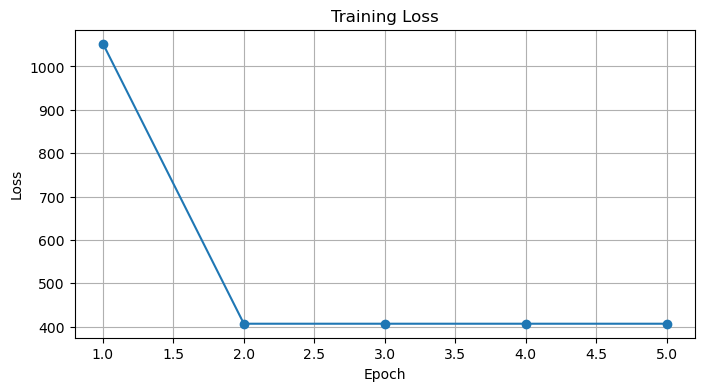

In [9]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

# 记录训练过程
epochs = 5
losses = []

for epoch in range(epochs):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    
    current_loss = float(l.sum())
    losses.append(current_loss)
    print(f'epoch {epoch + 1}, loss {current_loss:.6f}')

# 绘制损失曲线
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), losses, 'o-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

Raw network output: torch.Size([50, 50])
After taking diagonal: torch.Size([50])


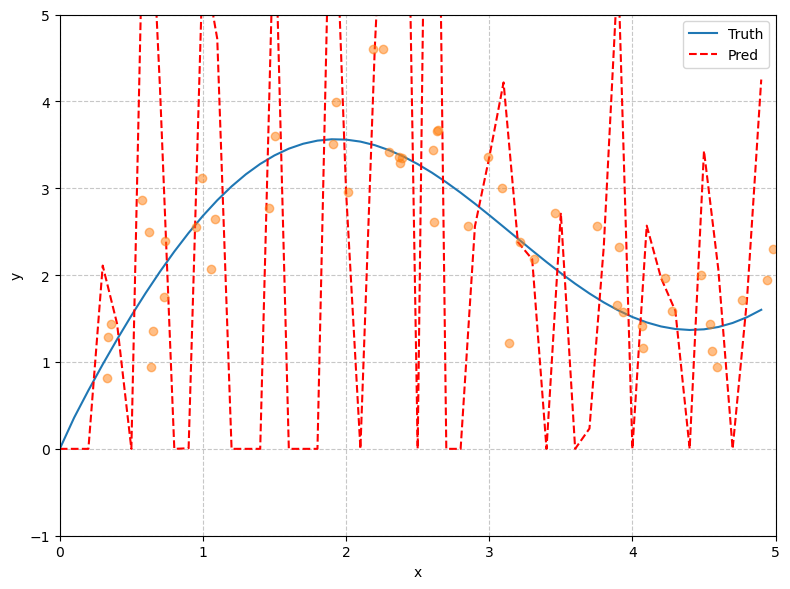

In [10]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))

with torch.no_grad():
    y_hat = net(x_test, keys, values)
    print(f"Raw network output: {y_hat.shape}")  # (50, 50)
    
    # 取对角线元素 - 这通常表示每个查询对应的预测
    y_hat = torch.diag(y_hat)
    print(f"After taking diagonal: {y_hat.shape}")  # (50,)

plot_kernel_reg(y_hat)

## 注意力评分函数
- 其实就是用来计算两个向量之间的相关性（相似度）的

![计算注意力汇聚](../image/AttentionPoolingProcess.png)

### 掩蔽$\mathrm{softmax}$操作
- 就是用来仅将有意义的词元作为值来获取注意力汇聚的，指定一个有效序列长度（就是词元的个数），然后就可以在$\mathrm{softmax}$的时候过滤掉超出指定长度的位置

In [11]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange(maxlen, dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X: 3D张量，valid_lens: 1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [12]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3701, 0.6299, 0.0000, 0.0000],
         [0.5297, 0.4703, 0.0000, 0.0000]],

        [[0.4478, 0.3317, 0.2205, 0.0000],
         [0.3435, 0.3772, 0.2793, 0.0000]]])

In [13]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2571, 0.4383, 0.3046, 0.0000]],

        [[0.5407, 0.4593, 0.0000, 0.0000],
         [0.2807, 0.3535, 0.1908, 0.1750]]])

### 加性注意力（通常针对查询和键是不同长度的矢量）
- 使用单隐藏层的前馈神经网络来计算分数的：
$$score(q, k)=v^T\tanh (W_qq+W_kk)$$
- 就是将$q$（查询）和$k$（键）分别通过线性变换（矩阵乘法$W$）后相加，经过$\tanh$激活函数，最后通过向量$v^T$投影成一个标量。

In [14]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，"键－值"对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，"键-值"对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，"键－值"对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

# 测试代码
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

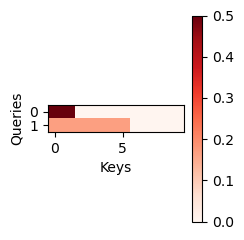

In [15]:


def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            # 将PyTorch张量转换为numpy数组
            if torch.is_tensor(matrices):
                matrix = matrices[i, j].detach().numpy()
            else:
                matrix = matrices[i, j]
            im = ax.imshow(matrix, cmap=cmap)
            
            if titles:
                ax.set_title(titles[i][j])
            
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            
            # 添加颜色条
            fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')

### 缩放点积注意力
- 为了解决在算注意力分数的时候，由于向量的维度过高，导致点积结果很大，然后在$\mathrm{Softmax}$的时候梯度变得很小（梯度消失）这个问题，让原本的结果除以一个**缩放因子**（键向量维度的平方根），这样就将这个分数缩放到了一个比较温和的数值范围。
$$\mathrm{softmax}\Big(\frac{\mathbf{QK}^T}{\sqrt{d}}\Big)\mathbf{V}\in\mathbb{R}^{n\times v}$$

In [16]:

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [17]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

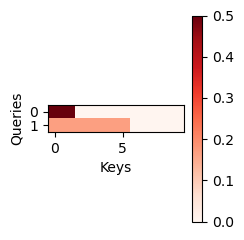

In [18]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')

## $\mathrm{Bahdanau}$注意力（加性注意力）
- 解码器在生成每个词时，不只依赖一个静态的向量，而是动态地“搜索”输入序列中最相关的部分。
- 该注意力方法允许$\mathrm{Decoder}$在生成的每一步都去查看$\mathrm{Encoder}$的所有隐藏状态，根据相关性赋予不同的权重：
  1. 计算相关性分数：<br>模型会计算$\mathrm{Decoder}$上一步的隐藏状态（$s_{t-1}$）与$\mathrm{Encoder}$每一个隐藏状态（$\mathrm{h_j}$）之间的匹配度（就是看当前的翻译语境和原文的哪个词关系最密切）。
  2. 计算注意力权重：<br>将上述分数通过$\mathrm{Softmax}$函数进行归一化，得到一组概率分布（和为$1$）。分值越高，说明该输入词对当前生成的词越重要。
  3. 计算上下文向量：<br>利用注意力权重，对$\mathrm{Encoder}$的所有隐藏状态进行加权求和，得到当前时刻专属的上下文向量 ($c_t$)。
  4. 生成输出：<br>利用$c_t$和$s_{t-1}$生成当前的隐藏状态$s_t$以及最终的单词$y_t$。
- 评分函数：给定$\mathrm{Decoder}$上一步状态$s_{t-1}$和$\mathrm{Encoder}$的第$j$个状态$h_j$，分数$e_{tj}$，
$$e_tj=v_a^T\tanh(W_as_{t-1}+U_ah_j)$$
- 其中$W_a$和$U_a$是可学习的权重矩阵，$v_a$是一个可学习的向量，$\tanh$是非线性激活函数。
- 归一化操作（$\mathrm{softmax}$）
$$\alpha_{tj}=\frac{exp(e_{tj})}{\sum^{T_x}_{k=1}{exp(e_{tk})}}$$
- 其中，$T_x$是输入序列的长度，$\alpha_{tj}$表示在生成第$t$个词时，应该给予第$j$个输入词多少关注。
- 上下文向量
$$c_t=\sum^{T_x}_{j=1}{\alpha_{tj}h_j}$$

![Bahdanau 注意力](../image/BahdanauAttention.png)

Running on device: cuda
Vocab size: Source=1118, Target=1243
Start Training...
Epoch 15, Loss: 107.940
Epoch 30, Loss: 83.191
Epoch 45, Loss: 70.940
Epoch 60, Loss: 63.702
Epoch 75, Loss: 58.182
Epoch 90, Loss: 54.191
Epoch 105, Loss: 50.865
Epoch 120, Loss: 48.285
Epoch 135, Loss: 46.237
Epoch 150, Loss: 44.688
Epoch 165, Loss: 42.722
Epoch 180, Loss: 41.621
Epoch 195, Loss: 39.838
Epoch 210, Loss: 38.815
Epoch 225, Loss: 38.118
Epoch 240, Loss: 37.286
Epoch 255, Loss: 36.380
Epoch 270, Loss: 35.854
Epoch 285, Loss: 35.465
Epoch 300, Loss: 34.393

Prediction Results:
go . => 回家。笑了。笑。”他, bleu 0.000
i lost . => 我没有结婚。。計生。, bleu 0.000
he's calm . => 他在過<unk>。。音争。”, bleu 0.000
i am home . => 我在家。他裡。.桌。, bleu 0.000

Displaying Heatmap for the last sentence...


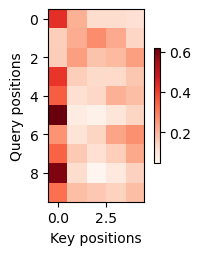

In [19]:
from torch.utils import data

# =============================================================================
# 1. 基础工具函数 (Utilities)
# =============================================================================

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行 softmax 操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

def grad_clipping(net, theta):
    """梯度裁剪"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图 (可视化注意力权重)"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    plt.show()

# =============================================================================
# 2. 数据处理与词表 (Data Processing & Vocab)
# =============================================================================

class Vocab:
    """词表类"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None: tokens = []
        if reserved_tokens is None: reserved_tokens = []

        # 统计词频
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # 构建映射
        self.idx_to_token = list(reserved_tokens)
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.token_to_idx.get('<unk>'))
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self): return 0
    @property
    def token_freqs(self): return self._token_freqs

def count_corpus(tokens):
    """统计词频"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def preprocess_nmt(text):
    """预处理：处理标点符号，确保英文标点与单词分开"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text, num_examples=None):
    """分词：英文按空格，中文按字符"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) >= 2:
            # Source: English (split by space)
            source.append(parts[0].split(' '))
            # Target: Chinese (character level)
            # 使用 list() 将 "我爱你" 变成 ['我', '爱', '你']
            target.append(list(parts[1]))
    return source, target

def truncate_pad(line, num_steps, padding_token):
    """截断或填充序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

def build_array_nmt(lines, vocab, num_steps):
    """将文本序列转换为索引张量"""
    lines = [vocab[l] for l in lines]
    lines = [truncate_pad(l, num_steps, vocab['<pad>']) for l in lines]
    array = torch.tensor(lines)
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

def load_data_nmt(batch_size, num_steps, num_examples=5000):
    """加载 cmn.txt 数据集"""
    # 读取文件
    try:
        with open('../data/cmn.txt', 'r', encoding='utf-8') as f:
            raw_text = f.read()
    except FileNotFoundError:
        print("错误：找不到文件 ../data/cmn.txt，请检查路径。")
        exit()

    text = preprocess_nmt(raw_text)
    source, target = tokenize_nmt(text, num_examples)

    # 构建词表
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<unk>', '<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<unk>', '<pad>', '<bos>', '<eos>'])

    # 构建张量
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)

    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    dataset = data.TensorDataset(*data_arrays)
    data_iter = data.DataLoader(dataset, batch_size, shuffle=True)

    return data_iter, src_vocab, tgt_vocab

# =============================================================================
# 3. 模型架构组件 (Model Architecture)
# =============================================================================
# (这部分代码与你提供的完全一致，未做修改)

class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super(Seq2SeqEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X).permute(1, 0, 2)
        output, state = self.rnn(X)
        return output.permute(1, 0, 2), state

class Seq2SeqAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super(Seq2SeqAttentionDecoder, self).__init__()
        self.attention = AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state, enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

# =============================================================================
# 4. 训练与预测 (Training & Prediction)
# =============================================================================

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear: nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param: nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()

    for epoch in range(num_epochs):
        metric = [0.0, 0.0]
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(net, 1)
            optimizer.step()
            metric[0] += l.sum().item()
            metric[1] += 1

        if (epoch + 1) % 15 == 0:
            print(f'Epoch {epoch + 1}, Loss: {metric[0] / metric[1]:.3f}')

def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    net.eval()
    # 预处理预测输入
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tensor = torch.tensor([src_tokens], dtype=torch.long, device=device)
    # Pad
    if len(src_tokens) < num_steps:
        pad_len = num_steps - len(src_tokens)
        src_tensor = torch.cat([src_tensor, torch.tensor([src_vocab['<pad>']] * pad_len, device=device).unsqueeze(0)], dim=1)

    enc_outputs = net.encoder(src_tensor, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)

    dec_input = torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device).unsqueeze(0)
    output_seq, attention_weight_seq = [], []

    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_input, dec_state)
        dec_input = Y.argmax(dim=2)
        pred = dec_input.squeeze(0).item()

        if save_attention_weights:
            # 这里的 [0] 是修正那个 list of tensors 的关键
            attention_weight_seq.append(net.decoder.attention_weights[0])

        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)

    return ''.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

def bleu(pred_seq, label_seq, k):
    """计算BLEU (针对字符级中文简单的实现)"""
    pred_tokens = list(pred_seq)
    label_tokens = list(label_seq)
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

# =============================================================================
# 5. 主程序 (Main Execution)
# =============================================================================

if __name__ == "__main__":
    # 配置
    embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
    batch_size, num_steps = 64, 10
    lr, num_epochs = 0.005, 300

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on device: {device}")

    # 1. 加载真实数据
    # num_examples 控制使用多少条数据训练，设小一点(如600)方便快速演示，
    # 设为 None 则使用全部数据 (可能需要调大网络和Epoch)
    train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps, num_examples=5000)
    print(f"Vocab size: Source={len(src_vocab)}, Target={len(tgt_vocab)}")

    # 2. 模型
    encoder = Seq2SeqEncoder(
        len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqAttentionDecoder(
        len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    net = EncoderDecoder(encoder, decoder)

    # 3. 训练
    print("Start Training...")
    train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

    # 4. 预测
    print("\nPrediction Results:")
    # 根据 cmn.txt 的内容选择一些简单的句子测试
    engs = ['go .', 'i lost .', 'he\'s calm .', 'i am home .']
    chns = ['走。', '我迷失了。', '他很冷静。', '我到家了。'] # 对应的中文供参考

    dec_attention_weight_seq = None

    for eng, chn in zip(engs, chns):
        translation, dec_attention_weight_seq = predict_seq2seq(
            net, eng, src_vocab, tgt_vocab, num_steps, device, True)
        print(f'{eng} => {translation}, bleu {bleu(translation, chn, k=2):.3f}')

    # 5. 可视化注意力
    if dec_attention_weight_seq:
        # 拼接: (1, pred_steps, 10)
        attention_weights = torch.cat(dec_attention_weight_seq, dim=1)

        # Reshape为 (1, 1, pred_steps, num_steps) 以适配 visualize
        # 注意：这里我们让最后一维也是动态的，不强制 resize 成 10，以防出错
        final_shape_weights = attention_weights.reshape((1, 1, -1, num_steps))

        # 截取对应输入长度的 Attention
        # (因为输入被 pad 到了 num_steps，但我们只关心实际单词的 attention)
        src_len = len(engs[-1].split()) + 1 # +1 for eos

        print("\nDisplaying Heatmap for the last sentence...")
        show_heatmaps(
            final_shape_weights[:, :, :, :src_len].cpu(),
            xlabel='Key positions',
            ylabel='Query positions'
        )

## 多头注意力

![多头注意力](../image/MultiHeadAttention.png)

- 整个过程就是，比如说对单句话来说的话，首先分词之后向量化，然后每一个词向量组成一个张量（矩阵），然后做投影处理（然后这个输入的张量乘以三个权重矩阵$W_Q、W_K、W_V$），然后得到的新的三个矩阵（$Q、K、V$）的每行的每个元素其实就是浓缩了对应词相关信息的元素，然后根据注意力头的个数对这些矩阵的所有列进行平均分配，对单个注意力头内部来说，用拆分之后的$Q、K$进行矩阵乘法，就是比对当前这个词在自己位置的信息、以及句中其它位置关于它的信息（就是计算分数），然后经过$\mathrm{Softmax}$归一成概率（注意力权重矩阵），然后用这个概率矩阵去乘对应拆分到这个注意力头的$V$矩阵（具体内容含义矩阵），然后得到的输出就是这个注意力头的输出；然后把各个头的输出拼接起来（就是左右拼接放一起），再乘以一个输出权重矩阵，就可以把所有的注意力结果信息揉匀，最终再输出（就是多头模型的输出了），最后转换成文字是通过，使用输出的矩阵的某行（代表的就是某个词），乘以一个字典矩阵（单个向量长度是词袋的大小，个数是输出矩阵行向量的长度），最后得到的就是这个词是字典中所有词的对应分数，然后归一化所有的分数就得到概率，概率最大的就是我们要选出来的词，最后的这个字典矩阵也是一个需要不断的学习更新的参数。（**自注意力**）
- 投影 -> 拆头 -> 并行$\mathrm{Attention}$ -> 拼接 -> 融合。
- 单个头的计算：
$$\mathrm{head_i}=\mathrm{Attention}(QW_i^Q,KW_I^K,VW_i^V)$$
- 整体多个头($h$个)计算：
$$\mathrm{MultiHead}(Q,K,V)=\mathrm{Concat(head_1,\dots,head_h)}W^O$$
- 上述两个公式里面的$W$都是可学习的参数矩阵。

In [20]:
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        """
        Args:
            d_model: 输入和输出的特征维度 (例如 512)
            num_heads: 注意力头的数量 (例如 8)
            dropout: Dropout 比率
        """
        super().__init__()
        assert d_model % num_heads == 0, "d_model 必须能被 num_heads 整除"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # 每个头的维度
        
        # 定义 Q, K, V 的线性投影层
        # 这里为了演示清晰，分开了三个层。
        # 在极致优化版本中，通常会合并为一个 nn.Linear(d_model, 3 * d_model)
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        
        # 最终输出的线性投影层
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        """
        Args:
            q: 查询向量 [Batch, Seq_Len_Q, d_model]
            k: 键向量   [Batch, Seq_Len_K, d_model]
            v: 值向量   [Batch, Seq_Len_K, d_model]
            mask: 掩码张量 (可选) [Batch, 1, Seq_Len_Q, Seq_Len_K] 或者 [Batch, 1, 1, Seq_Len_K]
                  通常 0 表示关注，1 (或 True) 表示忽略(掩蔽)。
        """
        batch_size = q.size(0)
        
        # 1. 线性投影 (Linear Projections)
        # 形状变化: [Batch, Seq_Len, d_model] -> [Batch, Seq_Len, d_model]
        Q = self.w_q(q)
        K = self.w_k(k)
        V = self.w_v(v)
        
        # 2. 拆分多头 (Split Heads)
        # 我们需要把 d_model 拆分为 num_heads * d_k
        # 变换流程: [Batch, Seq_Len, Heads * d_k] 
        #        -> [Batch, Seq_Len, Heads, d_k] 
        #        -> [Batch, Heads, Seq_Len, d_k] (Transpose，方便后续并行计算)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 3. 缩放点积注意力 (Scaled Dot-Product Attention)
        
        # 计算注意力分数: Score = Q * K^T / sqrt(d_k)
        # K.transpose(-2, -1) 是把最后两个维度交换，即 (d_k, Seq_Len)
        # 结果形状: [Batch, Heads, Seq_Len_Q, Seq_Len_K]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 应用 Mask (如果有)
        if mask is not None:
            # mask 为 0 (False) 的地方保留，为 1 (True) 的地方设为负无穷
            # 或者 mask 已经是 0/-inf 格式
            if mask.dtype == torch.bool:
                scores = scores.masked_fill(mask, float('-inf'))
            else:
                scores = scores + mask

        # Softmax 归一化
        attn_weights = F.softmax(scores, dim=-1)
        
        # Dropout
        attn_weights = self.dropout(attn_weights)
        
        # 加权求和: Output = Weights * V
        # 结果形状: [Batch, Heads, Seq_Len_Q, d_k]
        output = torch.matmul(attn_weights, V)
        
        # 4. 合并多头 (Merge Heads)
        # 变换流程: [Batch, Heads, Seq_Len_Q, d_k]
        #        -> [Batch, Seq_Len_Q, Heads, d_k] (Transpose回去)
        #        -> [Batch, Seq_Len_Q, d_model]    (Flatten/Reshape)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        # 5. 最终线性投影 (Final Linear Projection)
        return self.w_o(output)

# --- 测试代码 ---
# 配置参数
BATCH_SIZE = 2
SEQ_LEN = 10
D_MODEL = 512
NUM_HEADS = 8

# 1. 实例化模型
mha = MultiHeadAttention(d_model=D_MODEL, num_heads=NUM_HEADS)

# 2. 创建模拟输入 (Batch, Seq_Len, D_Model)
x = torch.randn(BATCH_SIZE, SEQ_LEN, D_MODEL)

# 3. 创建一个简单的 Mask (例如 padding mask，这里假设最后两个词是 pad)
# 形状通常需要广播到 [Batch, 1, 1, Seq_Len] 或者 [Batch, 1, Seq_Len, Seq_Len]
# 这里演示一个简单的 boolean mask: True 表示被遮蔽
mask = torch.zeros((BATCH_SIZE, 1, 1, SEQ_LEN), dtype=torch.bool)
mask[:, :, :, -2:] = True # 遮蔽最后两个词

# 4. 前向传播 (自注意力：Q=K=V=x)
output = mha(q=x, k=x, v=x, mask=mask)

print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")

# 验证输出维度是否和输入一致
assert output.shape == x.shape
print("测试通过！")

输入形状: torch.Size([2, 10, 512])
输出形状: torch.Size([2, 10, 512])
测试通过！


### 位置编码（在注意力机制中加入位置编码）
- 就是在词向量后面加一个位置向量（通常会使用正弦、余弦函数来生成位置向量）
$$PE_{(pos,2i)}=\sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)}=\cos(pos/10000^{2i/d_{model}})$$
- 其中，$pos$是词在句子中的位置，$i$是向量维度的索引。
- 绝对位置编码：就是上面这种直接用正弦、余弦函数计算出的位置编码。（$transformer$原版的使用方式）
- 相对位置编码：在自注意力计算中（得分计算），显式地加一个表示相对位置偏置的项（可学习的，并且只依赖于两个$token$的相对距离（位置序号相减），学习的距离关系效果好）。
- 旋转位置编码（$\mathrm{RoPE}$）：把词向量看作复数空间中的向量（其实就是方便旋转计算，把维度减半，就是原维度两两结合成复数维度中的一个维度，对应实部和虚部），对于序列中的第$m$个位置，将词向量的每一维都乘以一个旋转矩阵（矩阵的值由位置$m$决定），然后再进行注意力得分计算。
## $\mathrm{Transformer}$

![Transformer结构](../image/transformer.png)

- 输入处理：词向量加位置编码组成模型输入。
- 编码器：有多个完全相同的层组成，每层都包含两个核心子层，即多头自注意力机制和前馈神经网络，每个子层都有一个残差连接（缓解梯度消失问题）和层归一化（加速收敛）：$输出=\mathrm{LayerNorm}(子层输入+子层函数(子层输入))$
- 解码器：也是由多个完全相同的层堆叠而成，每层包含三个核心子层，即掩码多头自注意力机制（解码的时候只能看当前及之前的词，不能看以后的词，所以在计算注意力的时候要使用掩码屏蔽掉（一般是设置成一个极大的负值，这样$\mathrm{Softmax}$之后概率就为零）未来信息）、编码器-解码器注意力机制（$Q$来自解码器的上一子层，而$K、V$都来自编码器最终的输出）、前馈神经网络，同样，每个子层都有残差连接和层归一化。
- 输出层：解码器的输出经过一个线性层和一个$\mathrm{Softmax}$层，转换为一个概率分布，表示下一个单词是词汇表中每个词的概率。

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DaiYongle\AppData\Local\Temp\jieba.cache


开始加载和预处理数据...
正在加载数据集...


Loading model cost 0.937 seconds.
Prefix dict has been built successfully.


英文词汇表大小: 1917
中文词汇表大小: 3166
数据集大小: 5000
正在初始化Transformer模型...
模型参数数量: 1,722,078
开始训练...
Epoch: 1, Batch: 0, Loss: 8.0045
Epoch: 1, Batch: 50, Loss: 5.1352
Epoch: 1, Batch: 100, Loss: 4.8984
Epoch: 1, Batch: 150, Loss: 4.5291
Epoch 1/10, Average Loss: 5.1018, Time: 25.45s
Epoch: 2, Batch: 0, Loss: 4.0905
Epoch: 2, Batch: 50, Loss: 4.2334
Epoch: 2, Batch: 100, Loss: 4.0891
Epoch: 2, Batch: 150, Loss: 3.9793
Epoch 2/10, Average Loss: 3.9097, Time: 23.96s
Epoch: 3, Batch: 0, Loss: 3.6298
Epoch: 3, Batch: 50, Loss: 3.2480
Epoch: 3, Batch: 100, Loss: 3.3262
Epoch: 3, Batch: 150, Loss: 3.0567
Epoch 3/10, Average Loss: 3.3091, Time: 27.53s
Epoch: 4, Batch: 0, Loss: 2.8166
Epoch: 4, Batch: 50, Loss: 2.7065
Epoch: 4, Batch: 100, Loss: 2.8128
Epoch: 4, Batch: 150, Loss: 3.0556
Epoch 4/10, Average Loss: 2.7671, Time: 23.52s
Epoch: 5, Batch: 0, Loss: 2.4029
Epoch: 5, Batch: 50, Loss: 2.1405
Epoch: 5, Batch: 100, Loss: 1.9804
Epoch: 5, Batch: 150, Loss: 2.1824
Epoch 5/10, Average Loss: 2.2791, Time:

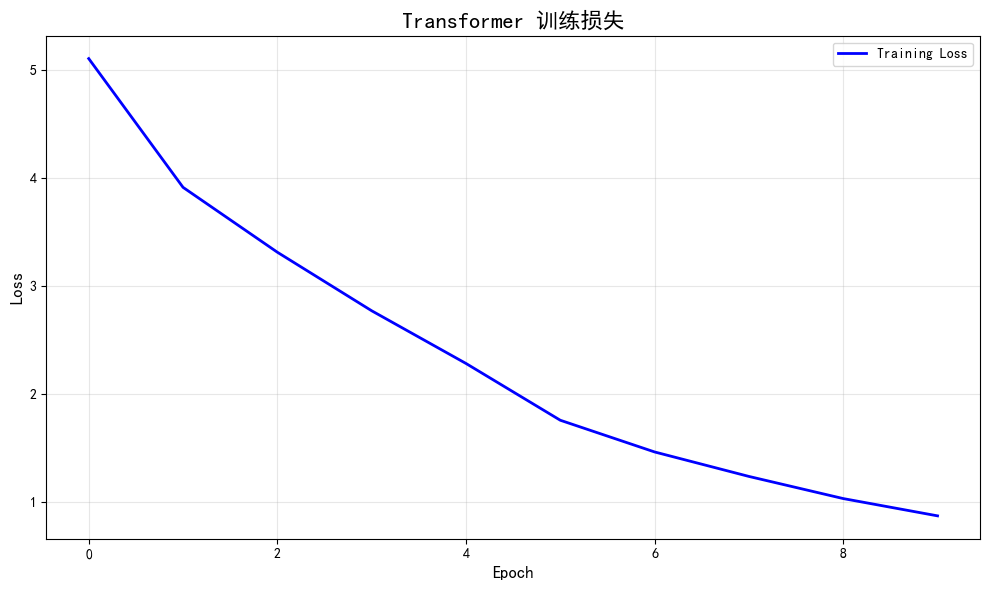


=== 翻译测试 ===

英文: hello world
参考翻译: 你好
模型翻译: 你好嗎
BLEU分数: 0.0000

英文: how are you
参考翻译: 多可爱啊
模型翻译: 你真好
BLEU分数: 0.0000

英文: what is your name
参考翻译: 啥
模型翻译: 你叫什么名字
BLEU分数: 0.0000

英文: i love machine learning
参考翻译: 嗨
模型翻译: 我爱音乐
BLEU分数: 0.0000

英文: the weather is nice today
参考翻译: 他们赢了
模型翻译: 今天很可爱
BLEU分数: 0.0000

平均BLEU分数: 0.0000

=== 训练和评估完成 ===
模型已保存为 'transformer_translator.pth'


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import re
import jieba
import math
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("开始加载和预处理数据...")

# 数据预处理类
class TranslationDataset(Dataset):
    def __init__(self, file_path, max_length=50, min_freq=2, max_samples=5000):
        self.max_length = max_length
        self.max_samples = max_samples
        self.en_sentences, self.zh_sentences = self.load_data(file_path)

        # 构建词汇表
        self.en_vocab, self.zh_vocab = self.build_vocab(min_freq)

        self.en_word2idx = {word: idx for idx, word in enumerate(self.en_vocab)}
        self.en_idx2word = {idx: word for idx, word in enumerate(self.en_vocab)}

        self.zh_word2idx = {word: idx for idx, word in enumerate(self.zh_vocab)}
        self.zh_idx2word = {idx: word for idx, word in enumerate(self.zh_vocab)}

        print(f"英文词汇表大小: {len(self.en_vocab)}")
        print(f"中文词汇表大小: {len(self.zh_vocab)}")
        print(f"数据集大小: {len(self.en_sentences)}")

    def load_data(self, file_path):
        en_sentences = []
        zh_sentences = []

        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if i >= self.max_samples:
                    break
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    en_sentences.append(self.preprocess_en(parts[0]))
                    zh_sentences.append(self.preprocess_zh(parts[1]))

        return en_sentences, zh_sentences

    def preprocess_en(self, text):
        text = text.lower()
        text = re.sub(r"([.!?])", r" \1", text)
        text = re.sub(r"[^a-zA-Z.!?]+", r" ", text)
        tokens = text.strip().split()
        return tokens

    def preprocess_zh(self, text):
        tokens = list(jieba.cut(text))
        tokens = [token for token in tokens if re.match(r'[\u4e00-\u9fff]', token)]
        return tokens

    def build_vocab(self, min_freq):
        en_counter = Counter()
        for sentence in self.en_sentences:
            en_counter.update(sentence)

        en_vocab = ['<pad>', '<sos>', '<eos>', '<unk>'] + \
                  [word for word, count in en_counter.items() if count >= min_freq]

        zh_counter = Counter()
        for sentence in self.zh_sentences:
            zh_counter.update(sentence)

        zh_vocab = ['<pad>', '<sos>', '<eos>', '<unk>'] + \
                  [word for word, count in zh_counter.items() if count >= min_freq]

        return en_vocab, zh_vocab

    def sentence_to_indices(self, sentence, is_english=True):
        if is_english:
            word2idx = self.en_word2idx
        else:
            word2idx = self.zh_word2idx

        indices = [word2idx.get('<sos>', 1)]
        for word in sentence[:self.max_length-2]:
            indices.append(word2idx.get(word, word2idx.get('<unk>', 3)))
        indices.append(word2idx.get('<eos>', 2))

        while len(indices) < self.max_length:
            indices.append(word2idx.get('<pad>', 0))

        return indices[:self.max_length]

    def __len__(self):
        return len(self.en_sentences)

    def __getitem__(self, idx):
        en_indices = self.sentence_to_indices(self.en_sentences[idx], is_english=True)
        zh_indices = self.sentence_to_indices(self.zh_sentences[idx], is_english=False)

        return torch.tensor(en_indices), torch.tensor(zh_indices)

# 位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# 简化的Transformer模型 - 移除复杂的注意力权重捕获
class SimpleTransformerTranslator(nn.Module):
    def __init__(self, en_vocab_size, zh_vocab_size, d_model=256, nhead=8,
                 num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512,
                 dropout=0.1, max_len=50):
        super(SimpleTransformerTranslator, self).__init__()

        self.d_model = d_model
        self.max_len = max_len

        # 词嵌入层
        self.en_embedding = nn.Embedding(en_vocab_size, d_model)
        self.zh_embedding = nn.Embedding(zh_vocab_size, d_model)

        # 位置编码
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # 输出层
        self.output_layer = nn.Linear(d_model, zh_vocab_size)

        # 初始化参数
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        # 嵌入和位置编码
        src_embed = self.en_embedding(src) * math.sqrt(self.d_model)
        tgt_embed = self.zh_embedding(tgt) * math.sqrt(self.d_model)

        src_embed = self.pos_encoding(src_embed)
        tgt_embed = self.pos_encoding(tgt_embed)

        # 创建掩码
        src_padding_mask = (src == 0)
        tgt_padding_mask = (tgt == 0)

        # 生成因果掩码
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(1))

        # Transformer前向传播
        output = self.transformer(
            src_embed, tgt_embed,
            src_mask=None,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask
        )

        # 输出层
        output = self.output_layer(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        """生成因果掩码"""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def translate(self, src, dataset, max_length=50):
        """简化的翻译函数 - 不返回注意力权重"""
        self.eval()
        with torch.no_grad():
            # 准备源序列
            src_indices = dataset.sentence_to_indices(
                dataset.preprocess_en(src), is_english=True
            )
            src_tensor = torch.tensor(src_indices).unsqueeze(0)

            # 初始化目标序列
            tgt_indices = [dataset.zh_word2idx['<sos>']]

            for i in range(max_length):
                tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0)

                output = self.forward(src_tensor, tgt_tensor)
                next_token = output[:, -1, :].argmax(dim=-1).item()

                if next_token == dataset.zh_word2idx['<eos>']:
                    break

                tgt_indices.append(next_token)

            # 转换为中文句子
            translated_words = []
            for idx in tgt_indices[1:]:
                if idx == dataset.zh_word2idx['<eos>']:
                    break
                word = dataset.zh_idx2word.get(idx, '<unk>')
                if word not in ['<pad>', '<sos>', '<eos>']:
                    translated_words.append(word)

            return ''.join(translated_words)

# 训练函数
def train_model(model, dataloader, dataset, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.zh_word2idx['<pad>'])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses = []

    print("开始训练...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        start_time = time.time()

        for batch_idx, (src, tgt) in enumerate(dataloader):
            optimizer.zero_grad()

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)

            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 50 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        epoch_time = time.time() - start_time

        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s')

    return train_losses

# 绘制训练损失图
def plot_training_loss(train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
    plt.title('Transformer 训练损失', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 计算BLEU分数
def calculate_bleu(reference, candidate):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    smooth = SmoothingFunction().method1
    return sentence_bleu([reference], candidate, smoothing_function=smooth)

# 主程序 - 简化版本，专注于训练和基本翻译
def main():
    # 加载数据集
    print("正在加载数据集...")
    dataset = TranslationDataset('../data/cmn.txt', max_length=30, min_freq=1, max_samples=5000)

    # 创建数据加载器
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

    # 初始化模型
    print("正在初始化Transformer模型...")
    model = SimpleTransformerTranslator(
        en_vocab_size=len(dataset.en_vocab),
        zh_vocab_size=len(dataset.zh_vocab),
        d_model=128,
        nhead=4,
        num_encoder_layers=2,
        num_decoder_layers=2,
        dim_feedforward=256,
        dropout=0.1,
        max_len=30
    )

    print(f"模型参数数量: {sum(p.numel() for p in model.parameters()):,}")

    # 训练模型
    train_losses = train_model(
        model, dataloader, dataset,
        num_epochs=10,
        learning_rate=0.001
    )

    # 绘制训练损失
    plot_training_loss(train_losses)

    # 测试翻译
    test_sentences = [
        "hello world",
        "how are you",
        "what is your name",
        "i love machine learning",
        "the weather is nice today"
    ]

    print("\n=== 翻译测试 ===")
    all_bleu_scores = []

    for i, en_sentence in enumerate(test_sentences):
        reference = None
        for j, (en, zh) in enumerate(zip(dataset.en_sentences, dataset.zh_sentences)):
            if en_sentence.split()[0] in ' '.join(en):
                reference = zh
                break

        translated = model.translate(en_sentence, dataset)

        print(f"\n英文: {en_sentence}")
        print(f"参考翻译: {''.join(reference) if reference else 'N/A'}")
        print(f"模型翻译: {translated}")

        if reference:
            bleu_score = calculate_bleu(reference, list(translated))
            all_bleu_scores.append(bleu_score)
            print(f"BLEU分数: {bleu_score:.4f}")

    if all_bleu_scores:
        avg_bleu = np.mean(all_bleu_scores)
        print(f"\n平均BLEU分数: {avg_bleu:.4f}")

    print("\n=== 训练和评估完成 ===")

    # 保存模型
    torch.save(model.state_dict(), 'transformer_translator.pth')
    print("模型已保存为 'transformer_translator.pth'")

if __name__ == "__main__":
    main()